In [95]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
from pathlib import Path
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [96]:
subj_list = behavioural_data = pd.read_csv('filtered_behavioural.csv', sep=';')
subj_list = np.array(subj_list['Subject'])

In [97]:
all_behav_data = pd.read_csv('filtered_behavioural.csv', sep=';')
all_behav_data.set_index('Subject', inplace=True)
print(all_behav_data.shape)
all_behav_data.head()

(339, 382)


,Release,Acquisition,Gender,Age,3T_Full_MR_Compl,T1_Count,T2_Count,3T_RS-fMRI_Count,3T_RS-fMRI_PctCompl,3T_Full_Task_fMRI,...,Noise_Comp,Odor_Unadj,Odor_AgeAdj,PainIntens_RawScore,PainInterf_Tscore,Taste_Unadj,Taste_AgeAdj,Mars_Log_Score,Mars_Errs,Mars_Final
Subject,,,,,,,,,,,,,,,,,,,,,
199453,S500,Q05,M,22-25,True,2,2,4,100.0,True,...,2.0,122.25,110.45,4.0,56.6,83.23,83.12,1.76,0.0,1.76
580751,S900,Q10,M,22-25,True,2,2,4,100.0,True,...,2.0,108.79,97.19,0.0,43.8,88.02,87.70,1.88,1.0,1.84
173435,S500,Q05,F,26-30,True,2,2,4,100.0,True,...,4.4,101.12,87.11,0.0,50.1,81.25,78.98,1.92,1.0,1.88
919966,S900,Q11,F,31-35,True,2,1,4,100.0,True,...,2.8,108.79,98.04,2.0,46.6,107.75,104.45,1.88,0.0,1.88
181636,S900,Q08,F,31-35,True,2,1,4,100.0,True,...,4.4,122.25,111.41,0.0,38.6,99.67,98.45,1.80,0.0,1.80


# Basicl Parameters 

In [98]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp"
if not os.path.isdir(HCP_DIR):
  os.mkdir(HCP_DIR)

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 339

# The data have already been aggregated into ROIs from the Glasesr parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in sec

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated multiple times in each subject
N_RUNS_REST = 4
N_RUNS_TASK = 2

# Time series data are organized by experiment, with each experiment
# having an LR and RL (phase-encode direction) acquistion
BOLD_NAMES = [
  "rfMRI_REST1_LR", "rfMRI_REST1_RL",
  "rfMRI_REST2_LR", "rfMRI_REST2_RL",
  "tfMRI_MOTOR_RL", "tfMRI_MOTOR_LR",
  "tfMRI_WM_RL", "tfMRI_WM_LR",
  "tfMRI_EMOTION_RL", "tfMRI_EMOTION_LR",
  "tfMRI_GAMBLING_RL", "tfMRI_GAMBLING_LR",
  "tfMRI_LANGUAGE_RL", "tfMRI_LANGUAGE_LR",
  "tfMRI_RELATIONAL_RL", "tfMRI_RELATIONAL_LR",
  "tfMRI_SOCIAL_RL", "tfMRI_SOCIAL_LR"
]

# You may want to limit the subjects used during code development.
# This will use all subjects:
subjects = range(N_SUBJECTS)

In [99]:
def get_image_ids(name):
  """Get the 1-based image indices for runs in a given experiment.

    Args:
      name (str) : Name of experiment ("rest" or name of task) to load
    Returns:
      run_ids (list of int) : Numeric ID for experiment image files

  """
  run_ids = [
    i for i, code in enumerate(BOLD_NAMES, 1) if name.upper() in code
  ]
  if not run_ids:
    raise ValueError(f"Found no data for '{name}''")
  return run_ids

def load_timeseries(subject, name, runs=None, concat=True, remove_mean=True):
  """Load timeseries data for a single subject.
  
  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of experiment ("rest" or name of task) to load
    run (None or int or list of ints): 0-based run(s) of the task to load,
      or None to load all runs.
    concat (bool) : If True, concatenate multiple runs in time
    remove_mean (bool) : If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_tp array): Array of BOLD data values

  """
  # Get the list relative 0-based index of runs to use
  if runs is None:
    runs = range(N_RUNS_REST) if name == "rest" else range(N_RUNS_TASK)
  elif isinstance(runs, int):
    runs = [runs]

  # Get the first (1-based) run id for this experiment 
  offset = get_image_ids(name)[0]

  # Load each run's data
  bold_data = [
      load_single_timeseries(subject, offset + run, remove_mean) for run in runs
  ]

  # Optionally concatenate in time
  if concat:
    bold_data = np.concatenate(bold_data, axis=-1)

  return bold_data


def load_single_timeseries(subject, bold_run, remove_mean=True):
  """Load timeseries data for a single subject and single run.
  
  Args:
    subject (int): 0-based subject ID to load
    bold_run (int): 1-based run index, across all tasks
    remove_mean (bool): If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_path = f"{HCP_DIR}/subjects/{subject}/timeseries"
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts

def load_evs(subject, name, condition):
  """Load EV (explanatory variable) data for one task condition.

  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of task
    condition (str) : Name of condition

  Returns
    evs (list of dicts): A dictionary with the onset, duration, and amplitude
      of the condition for each run.

  """
  evs = []
  for id in get_image_ids(name):
    task_key = BOLD_NAMES[id - 1]
    ev_file = f"{HCP_DIR}/subjects/{subject}/EVs/{task_key}/{condition}.txt"
    ev = dict(zip(["onset", "duration", "amplitude"], np.genfromtxt(ev_file).T))
    evs.append(ev)
  return evs

# Calculate the FC matrix for Resting State

In [100]:
from nilearn.connectome import sym_matrix_to_vec

timeseries_rest = []
for subject in subjects:
  ts_concat = load_timeseries(subject, "rest")
  timeseries_rest.append(ts_concat)

timeseries_rest_array = np.array(timeseries_rest)

all_fc_data = np.zeros((339, 64980))

fc = np.zeros((N_SUBJECTS, N_PARCELS, N_PARCELS))
for sub, ts in enumerate(timeseries_rest):
  fc[sub] = np.corrcoef(ts)

fc.shape




(339, 360, 360)

In [101]:
#all_fc_data = {}
all_fc_data = np.zeros((339, 64620))


prova = sym_matrix_to_vec(fc[0], discard_diagonal=True)
for subject in range(subj_list.shape[0]):
    #all_fc_data[subject,:] = sym_matrix_to_vec(fc[subject,:,:], discard_diagonal=True)
    all_fc_data[subject,:] = fc[subject][np.triu_indices_from(fc[subject], k=1)]

all_fc_data = pd.DataFrame(data=all_fc_data, index=subj_list)
all_fc_data.head()

,0,1,2,3,4,5,6,7,8,9,...,64610,64611,64612,64613,64614,64615,64616,64617,64618,64619
199453,0.526951,0.730541,0.848474,0.750381,0.699462,0.525369,0.506014,0.564495,0.488659,0.419007,...,0.456616,0.102529,0.302767,0.272905,0.275728,0.486999,0.335681,0.422162,0.270636,0.702395
580751,0.632350,0.617932,0.853963,0.817077,0.770512,0.575790,0.477863,0.487551,0.461145,0.375246,...,0.660628,0.246444,0.331124,0.474321,0.299301,0.266923,0.500596,0.277612,0.282218,0.419214
173435,0.488273,0.692258,0.845288,0.827605,0.757000,0.623675,0.479999,0.495218,0.600098,0.464961,...,0.469831,0.306765,0.216664,0.239942,0.171997,0.197644,0.221915,0.222744,0.233991,0.506188
919966,0.334041,0.376532,0.813939,0.727403,0.751033,0.434621,0.659445,0.586108,0.595027,0.576529,...,0.169793,0.297801,0.187307,0.313417,0.112833,0.091015,0.262348,0.180193,0.398764,0.358900
181636,0.630173,0.737913,0.864156,0.832878,0.788949,0.716571,0.511337,0.381727,0.556570,0.352062,...,0.518038,0.621262,0.349018,0.278242,0.411510,0.241910,0.091272,0.461904,0.451890,0.640577


n_nodes*(n_nodes-1)/2, where n_nodes here = 360

Let's read in the resting-state FC matrices for each subject in subj_list:

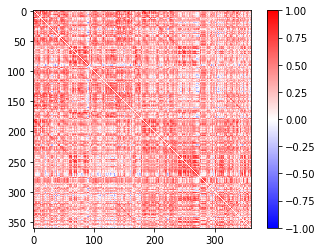

In [102]:
s = 1

plt.imshow(sp.spatial.distance.squareform(all_fc_data.iloc[s,:]), interpolation="none", cmap="bwr", vmin=-1, vmax=1)
plt.colorbar()
plt.show()


## Define CPM functions

In [103]:
def mk_kfold_indices(subj_list, k = 10):
    """
    Splits list of subjects into k folds for cross-validation.
    """
    
    n_subs = len(subj_list)
    n_subs_per_fold = n_subs//k # floor integer for n_subs_per_fold

    indices = [[fold_no]*n_subs_per_fold for fold_no in range(k)] # generate repmat list of indices
    remainder = n_subs % k # figure out how many subs are left over
    remainder_inds = list(range(remainder))
    indices = [item for sublist in indices for item in sublist]    
    [indices.append(ind) for ind in remainder_inds] # add indices for remainder subs

    assert len(indices)==n_subs, "Length of indices list does not equal number of subjects, something went wrong"

    np.random.shuffle(indices) # shuffles in place

    return np.array(indices)

In [104]:
def split_train_test(subj_list, indices, test_fold):
    """
    For a subj list, k-fold indices, and given fold, returns lists of train_subs and test_subs
    """

    train_inds = np.where(indices!=test_fold)
    test_inds = np.where(indices==test_fold)

    train_subs = []
    for sub in subj_list[train_inds]:
        train_subs.append(sub)

    test_subs = []
    for sub in subj_list[test_inds]:
        test_subs.append(sub)

    return (train_subs, test_subs)

In [105]:
def get_train_test_data(all_fc_data, train_subs, test_subs, behav_data, behav):

    """
    Extracts requested FC and behavioral data for a list of train_subs and test_subs
    """

    train_vcts = all_fc_data.loc[train_subs, :]
    test_vcts = all_fc_data.loc[test_subs, :]

    train_behav = behav_data.loc[train_subs, behav]

    return (train_vcts, train_behav, test_vcts)

In [106]:
def select_features(train_vcts, train_behav, r_thresh=0.2, corr_type='pearson', verbose=False):
    
    """
    Runs the CPM feature selection step: 
    - correlates each edge with behavior, and returns a mask of edges that are correlated above some threshold, one for each tail (positive and negative)
    """

    assert train_vcts.index.equals(train_behav.index), "Row indices of FC vcts and behavior don't match!"

    # Correlate all edges with behav vector
    if corr_type =='pearson':
        cov = np.dot(train_behav.T - train_behav.mean(), train_vcts - train_vcts.mean(axis=0)) / (train_behav.shape[0]-1)
        corr = cov / np.sqrt(np.var(train_behav, ddof=1) * np.var(train_vcts, axis=0, ddof=1))
    elif corr_type =='spearman':
        corr = []
        for edge in train_vcts.columns:
            r_val = sp.stats.spearmanr(train_vcts.loc[:,edge], train_behav)[0]
            corr.append(r_val)

    # Define positive and negative masks
    mask_dict = {}
    mask_dict["pos"] = corr > r_thresh
    mask_dict["neg"] = corr < -r_thresh
    
    if verbose:
        print("Found ({}/{}) edges positively/negatively correlated with behavior in the training set".format(mask_dict["pos"].sum(), mask_dict["neg"].sum())) # for debugging

    return mask_dict

In [107]:
def build_model(train_vcts, mask_dict, train_behav):
    """
    Builds a CPM model:
    - takes a feature mask, sums all edges in the mask for each subject, and uses simple linear regression to relate summed network strength to behavior
    """

    assert train_vcts.index.equals(train_behav.index), "Row indices of FC vcts and behavior don't match!"

    model_dict = {}

    # Loop through pos and neg tails
    X_glm = np.zeros((train_vcts.shape[0], len(mask_dict.items())))

    t = 0
    for tail, mask in mask_dict.items():
        X = train_vcts.values[:, mask].sum(axis=1)
        X_glm[:, t] = X
        y = train_behav
        (slope, intercept) = np.polyfit(X, y, 1)
        model_dict[tail] = (slope, intercept)
        t+=1

    X_glm = np.c_[X_glm, np.ones(X_glm.shape[0])]
    model_dict["glm"] = tuple(np.linalg.lstsq(X_glm, y, rcond=None)[0])

    return model_dict

In [108]:
def apply_model(test_vcts, mask_dict, model_dict):
    """
    Applies a previously trained linear regression model to a test set to generate predictions of behavior.
    """

    behav_pred = {}

    X_glm = np.zeros((test_vcts.shape[0], len(mask_dict.items())))

    # Loop through pos and neg tails
    t = 0
    for tail, mask in mask_dict.items():
        X = test_vcts.loc[:, mask].sum(axis=1)
        X_glm[:, t] = X

        slope, intercept = model_dict[tail]
        behav_pred[tail] = slope*X + intercept
        t+=1

    X_glm = np.c_[X_glm, np.ones(X_glm.shape[0])]
    behav_pred["glm"] = np.dot(X_glm, model_dict["glm"])

    return behav_pred

OK, now let's put all that together in a "wrapper" function that will go through and perform a full k-fold cross-validated CPM analysis:

In [109]:
def cpm_wrapper(all_fc_data, all_behav_data, behav, k=10, **cpm_kwargs):

    assert all_fc_data.index.equals(all_behav_data.index), "Row (subject) indices of FC vcts and behavior don't match!"

    subj_list = all_fc_data.index # get subj_list from df index
    
    indices = mk_kfold_indices(subj_list, k=k)
    
    # Initialize df for storing observed and predicted behavior
    col_list = []
    for tail in ["pos", "neg", "glm"]:
        col_list.append(behav + " predicted (" + tail + ")")
    col_list.append(behav + " observed")
    behav_obs_pred = pd.DataFrame(index=subj_list, columns = col_list)
    
    # Initialize array for storing feature masks
    n_edges = all_fc_data.shape[1]
    all_masks = {}
    all_masks["pos"] = np.zeros((k, n_edges))
    all_masks["neg"] = np.zeros((k, n_edges))
    
    for fold in range(k):
        print("doing fold {}".format(fold))
        train_subs, test_subs = split_train_test(subj_list, indices, test_fold=fold)
        train_vcts, train_behav, test_vcts = get_train_test_data(all_fc_data, train_subs, test_subs, all_behav_data, behav=behav)
        mask_dict = select_features(train_vcts, train_behav, **cpm_kwargs)
        all_masks["pos"][fold,:] = mask_dict["pos"]
        all_masks["neg"][fold,:] = mask_dict["neg"]
        model_dict = build_model(train_vcts, mask_dict, train_behav)
        behav_pred = apply_model(test_vcts, mask_dict, model_dict)
        for tail, predictions in behav_pred.items():
            behav_obs_pred.loc[test_subs, behav + " predicted (" + tail + ")"] = predictions
            
    behav_obs_pred.loc[subj_list, behav + " observed"] = all_behav_data[behav]
    
    return behav_obs_pred, all_masks

In [110]:
condition = 'REST'

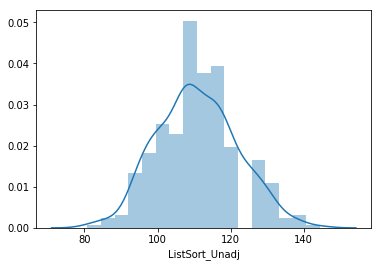

In [159]:
behav = 'ListSort_Unadj'

def fixed_bugged_column(df, column):
    df[column] = df[column].apply(lambda x: float(x.split()[0].replace(',', ''))) 
    for lines in range(len(df[column])): 
        if df[column][lines]>100:  
            df[column][lines]=df[column][lines] / 10**(len(str(df[column][lines])) - 4)    
    for lines in range(len(df[column])):  
          if df[column][lines]>100:
                df[column][lines]=df[column][lines] / 10**(len(str(df[column][lines])) - 4)  
                

all_behav_data = pd.read_csv('filtered_behavioural.csv', sep=';')


#fixed_bugged_column(all_behav_data, behav)               
all_behav_data.set_index('Subject', inplace=True)


all_behav_data[behav].fillna((all_behav_data[behav].mean()), inplace=True)

sns.distplot(all_behav_data[behav])
plt.show()


Now we run our CPM!

In [173]:
cpm_kwargs = {'r_thresh': 0.15, 'corr_type': 'pearson'} # these are the defaults, but it's still good to be explicit

behav_obs_pred, all_masks = cpm_wrapper(all_fc_data, all_behav_data, behav=behav, **cpm_kwargs)

doing fold 0
doing fold 1
doing fold 2
doing fold 3
doing fold 4
doing fold 5
doing fold 6
doing fold 7
doing fold 8
doing fold 9


In [174]:
behav_obs_pred.head()

,ListSort_Unadj predicted (pos),ListSort_Unadj predicted (neg),ListSort_Unadj predicted (glm),ListSort_Unadj observed
199453,115.619,104.744,110.035,121.89
580751,113.264,110.528,114.607,126.18
173435,112.342,111.128,113.832,121.89
919966,110.636,111.801,112.931,96.99
181636,112.754,104.131,102.389,96.99


Now we'll make a function that makes pretty scatter plots of observed versus predicted behavior:

In [175]:
def plot_predictions(behav_obs_pred, tail="glm"):
    x = behav_obs_pred.filter(regex=("obs")).astype(float)
    y = behav_obs_pred.filter(regex=(tail)).astype(float)

    g = sns.regplot(x=x.T.squeeze(), y=y.T.squeeze(), color='gray')
    ax_min = min(min(g.get_xlim()), min(g.get_ylim()))
    ax_max = max(max(g.get_xlim()), max(g.get_ylim()))
    g.set_xlim(ax_min, ax_max)
    g.set_ylim(ax_min, ax_max)
    g.set_aspect('equal', adjustable='box')
    
    r = sp.stats.pearsonr(x,y)[0][0]
    g.annotate('r = {0:.2f}'.format(r), xy = (0.7, 0.1), xycoords = 'axes fraction')
    
    return g

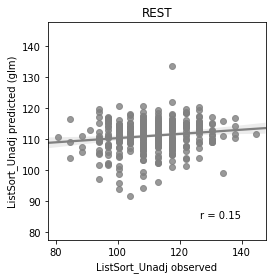

In [176]:
condition = 'REST'
g = plot_predictions(behav_obs_pred)
g.set_title(condition)
plt.show()

## Visualize edges

In [177]:
coordinates = pd.read_excel('Glasser_coordinates.xlsx', header=None)
print(coordinates.shape)
coordinates.head()

(360, 3)


,0,1,2
0,0.000000,-70.000000,14.666667
1,-40.000000,-60.000000,0.000000
2,-13.185629,-79.592814,28.982036
3,-10.350562,-81.126592,-0.254682
4,-11.141388,-91.778920,21.496144


In [178]:
from nilearn.plotting import plot_connectome

Now we define a function that will take in `all_masks`, calculate the consistency of each edge (i.e., how frequently it is selected across all k-fold iterations), and visualize only those edges that meet some consistency threshold (expressed as a percentage of times selected):

In [179]:
def plot_consistent_edges(all_masks, tail, thresh = 1., color='gray'):
    
    edge_frac = (all_masks[tail].sum(axis=0))/(all_masks[tail].shape[0])
    print("For the {} tail, {} edges were selected in at least {}% of folds".format(tail, (edge_frac>=thresh).sum(), thresh*100))
    edge_frac_square = sp.spatial.distance.squareform(edge_frac)

    node_mask = np.amax(edge_frac_square, axis=0) >= thresh # find nodes that have at least one edge that passes the threshold
    node_size = edge_frac_square.sum(axis=0)*node_mask*20 # size nodes based on how many suprathreshold edges they have

    plot_connectome(adjacency_matrix=edge_frac_square, edge_threshold=thresh,
                    node_color = color,
                    node_coords=coordinates, node_size=node_size,
                    display_mode= 'lzry',
                    edge_kwargs={"linewidth": 1, 'color': color})

For the pos tail, 38 edges were selected in at least 80.0% of folds


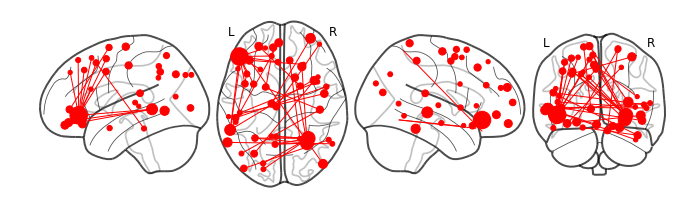

In [188]:
plot_consistent_edges(all_masks, "pos", thresh = 0.8, color = 'red')

For the neg tail, 39 edges were selected in at least 95.0% of folds


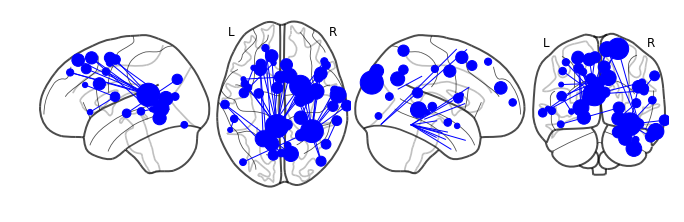

In [190]:
plot_consistent_edges(all_masks, "neg", thresh = 0.95, color = 'blue')